In [ ]:
import sys
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import spacy
from tabulate import tabulate
from tqdm import tqdm

In [ ]:
# TextDataset is Described in Section 3.3 of Assignment 2
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["comment_text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
# my_collate_function prepares batches
# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [ ]:
def createDatasets(df):
    df['label'] = np.where(((df["toxic"] == 1) | (df["severe_toxic"] == 1) | (df["obscene"] == 1) | (df["threat"] == 1) | (df["insult"] == 1) | (df["identity_hate"] == 1)), 1, 0)
    train, test = train_test_split(df[['comment_text', 'label']], test_size=0.2, random_state=0, stratify=df[['label']])

    trainFinal, val = train_test_split(train, test_size=0.2, random_state=0, stratify=train['label'])

    #writing to train, val and test tsv
    trainFinal.to_csv('/content/data/train.tsv', sep="\t", index=False)
    test.to_csv('/content/data/test.tsv', sep="\t", index=False)
    val.to_csv('/content/data/validation.tsv', sep="\t", index=False)

    #checking if number of positive and negative samples are the same
    if trainFinal[trainFinal.label == 1].shape[0] == trainFinal[trainFinal.label == 0].shape[0]:
        print("Number of positive and negative samples in the train set are equal.")
    if test[test.label == 1].shape[0] == test[test.label == 0].shape[0]:
        print("Number of positive and negative samples in the test set are equal.")
    if val[val.label == 1].shape[0] == val[val.label == 0].shape[0]:
        print("Number of positive and negative samples in the validation set are equal.")


    #checking if any common rows between train and test datasets
    df3  = pd.merge(trainFinal, test, on="comment_text", how='inner', indicator='Exist')
    df3  = df3.loc[df3['Exist'] != 'both']
    print("Printing number of common rows between train and test datasets: ", df3.shape[0])

    if (df3.shape[0] == 0):
        print("Train and test datsets are unique with no common rows")


    #checking if any common rows between train and validation datasets
    df3  = pd.merge(trainFinal, val, on="comment_text", how='inner', indicator='Exist')
    df3  = df3.loc[df3['Exist'] != 'both']
    print("Printing number of common rows between train and validation datasets: ", df3.shape[0])

    if (df3.shape[0] == 0):
        print("Train and validation datsets are unique with no common rows")


    #checking if any common rows between test and validation datasets
    df3  = pd.merge(test, val, on="comment_text", how='inner', indicator='Exist')
    df3  = df3.loc[df3['Exist'] != 'both']
    print("Printing number of common rows between test and validation datasets: ", df3.shape[0])

    if (df3.shape[0] == 0):
        print("Test and validation datsets are unique with no common rows")

In [ ]:
def main(batch_size):
    mydata = []
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #read data.tsv and splitting to train (64%), test (20%), val (16%)
    df = pd.read_csv("train.csv")
    createDatasets(df)

    ### 3.3 Processing of the data ###
    # 3.3.1
    # The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
    glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100

    # 3.3.2

    train_dataset = TextDataset(glove, "train")
    val_dataset = TextDataset(glove, "validation")
    test_dataset = TextDataset(glove, "test")
        
    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))
    
    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))
    
    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))
    
    predictionBaselineModel = trainBaselineModel(train_dataloader, validation_dataloader,test_dataloader, glove, 100, batch_size, 50, 0.001)
    torch.save(predictionBaselineModel, '{}.pt'.format("baseline"))

In [ ]:
class Baseline(nn.Module):
  def __init__(self, embedding_dim, vocab):
    super(Baseline, self).__init__()
    self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
    self.fc = nn.Linear(embedding_dim, 1)

  def forward(self, x, lengths=None):
    #x has shape [sentence length, batch size]
    embedded = self.embedding(x)
    average = embedded.mean(0) # [sent len, batch size, emb dim]
    output = self.fc(average)
    output = torch.sigmoid(output)
    return output

In [ ]:
def evaluate(model, dataLoader, criterion, batch_size):
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        total_corr = 0
        p =0
        for index,context in iter(dataLoader):
            index = index.type(torch.long)
            context = context.type(torch.float)
            logits = model(index)
            loss = criterion(logits.squeeze(), context)
            test_loss += float(loss)/batch_size
            p += 1
            corr = (logits > 0.5).squeeze().long() == context
            total_corr += int(corr.sum())
    return test_loss, total_corr, p

In [ ]:
def trainBaselineModel(train_dataloader, validation_dataloader, test_dataloader, vocab, embedding_size, batch_size, epochs, lr):
    model = Baseline(100, vocab)
    criterion = torch.nn.BCEWithLogitsLoss()
    opt_func = torch.optim.Adam
    optimizer = opt_func(model.parameters(), lr)       

    train_loss_list = []
    val_loss_list = []
    test_loss_list = []
    train_acc = []
    val_acc = []
    test_acc = []

    #train model using train set
    iters = np.arange(0,epochs)
    for epoch in range(epochs):
        train_loss= 0.0
        total_corr = 0
        model.train()
        n = 0
        for index,context in tqdm(iter(train_dataloader)): 
            index = index.type(torch.long)
            context = context.type(torch.float)
            logits = model(index)
            loss = criterion(logits.squeeze(), context)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss = train_loss + float(loss)/batch_size
            n += 1
            corr = (logits > 0.5).squeeze().long() == context
            total_corr += int(corr.sum())
        train_loss_list.append(train_loss/n)
        train_acc.append(float(total_corr) / len(train_dataloader.dataset))

        #evaluate validation set
        val_loss, total_corr, p = evaluate(model, validation_dataloader, criterion, batch_size)
        val_loss_list.append(val_loss/p) 
        val_acc.append(float(total_corr) / len(validation_dataloader.dataset))

        #evaluate test set
        test_loss, total_corr, p = evaluate(model, test_dataloader, criterion, batch_size)
        test_loss_list.append(test_loss/p) 
        test_acc.append(float(total_corr) / len(test_dataloader.dataset))

    print("Training Accuracy: " + str(train_acc[-1]), "Training Loss: " + str(train_loss_list[-1]))

    print("Validation Accuracy: " + str(val_acc[-1]), "Validation Loss: " + str(val_loss_list[-1]))

    print("Test Accuracy: " + str(test_acc[-1]), "Test Loss: " + str(test_loss_list[-1]))

    plt.title("Loss Curve")
    plt.plot(iters, train_loss_list, label="Train")
    plt.plot(iters, val_loss_list, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    #plot Accuracy curve
    plt.title("Accuracy Curve")
    plt.plot(iters, train_acc, label="Train accuracy")
    plt.plot(iters, val_acc, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.title("Loss Curve")
    plt.plot(iters, train_loss_list, label="Train")
    plt.plot(iters, test_loss_list, label="Test")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    #plot Accuracy curve
    plt.title("Accuracy Curve")
    plt.plot(iters, train_acc, label="Train accuracy")
    plt.plot(iters, test_acc, label="Test accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
    return model

Printing number of common rows between train and test datasets:  0
Train and test datsets are unique with no common rows
Printing number of common rows between train and validation datasets:  0
Train and validation datsets are unique with no common rows
Printing number of common rows between test and validation datasets:  0
Test and validation datsets are unique with no common rows


.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|██████████| 10213/10213 [00:17<00:00, 590.25it/s]


Training Accuracy: 0.9000430848772081 Training Loss: 0.06926097524956323
Validation Accuracy: 0.9000469998433338 Validation Loss: 0.06925579558710827
Test Accuracy: 0.8997963340122199 Test Loss: 0.06926812584089455


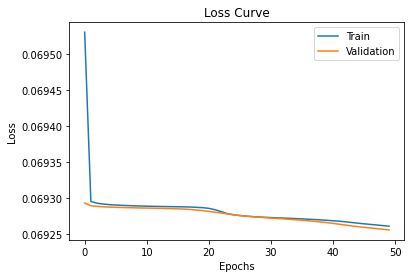

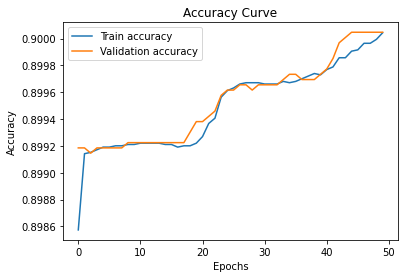

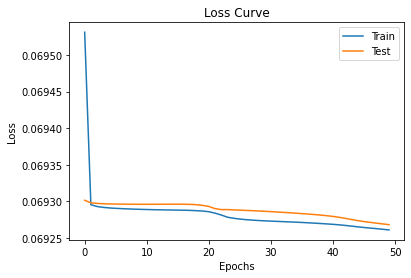

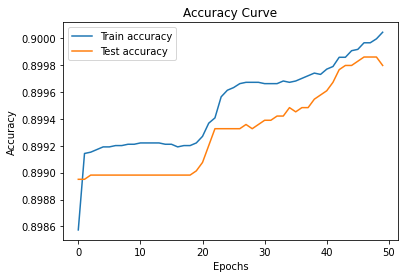

In [ ]:
if __name__ == '__main__':
    main(10)